This tutorial is for demonstrating DeepScalper using CNY to US Dollar

## Step 1: Import Packages
Modify the system path and load the corresponding packages and functions 

In [2]:
import os
import sys

import warnings
warnings.filterwarnings("ignore")

ROOT = os.path.dirname(os.path.abspath("."))
sys.path.append(ROOT)

import torch
import argparse
import os.path as osp
from mmcv import Config
from trademaster.utils import replace_cfg_vals
from trademaster.nets.builder import build_net
from trademaster.environments.builder import build_environment
from trademaster.datasets.builder import build_dataset
from trademaster.agents.builder import build_agent
from trademaster.optimizers.builder import build_optimizer
from trademaster.losses.builder import build_loss
from trademaster.trainers.builder import build_trainer
from trademaster.transition.builder import build_transition
from trademaster.utils import plot

## Step 2: Load Configs
Load default config from the folder `configs/algorithmic_trading/algorithmic_trading_FX_deepscalper_deepscalper_adam_mse.py`

In [3]:

parser = argparse.ArgumentParser(description='Download Alpaca Datasets')
parser.add_argument("--config", default=osp.join(ROOT, "configs", "algorithmic_trading", "algorithmic_trading_FX_deepscalper_deepscalper_adam_mse.py"),
                    help="download datasets config file path")
parser.add_argument("--task_name", type=str, default="train")
args, _= parser.parse_known_args()

cfg = Config.fromfile(args.config)
task_name = args.task_name
cfg = replace_cfg_vals(cfg)

In [4]:
cfg

Config (path: E:\workspace\RA\TradeMaster\configs\algorithmic_trading\algorithmic_trading_FX_deepscalper_deepscalper_adam_mse.py): {'data': {'type': 'AlgorithmicTradingDataset', 'data_path': 'data/algorithmic_trading/FX', 'train_path': 'data/algorithmic_trading/FX/train.csv', 'valid_path': 'data/algorithmic_trading/FX/valid.csv', 'test_path': 'data/algorithmic_trading/FX/test.csv', 'test_dynamic_path': 'data/algorithmic_trading/FX/test_labeled_3_24_-0.15_0.15.csv', 'tech_indicator_list': ['high', 'low', 'open', 'close', 'adjcp', 'zopen', 'zhigh', 'zlow', 'zadjcp', 'zclose', 'zd_5', 'zd_10', 'zd_15', 'zd_20', 'zd_25', 'zd_30'], 'backward_num_day': 5, 'forward_num_day': 5, 'test_dynamic': '-1'}, 'environment': {'type': 'AlgorithmicTradingEnvironment'}, 'agent': {'type': 'AlgorithmicTradingDQN', 'max_step': 12345, 'reward_scale': 1, 'repeat_times': 1, 'gamma': 0.9, 'batch_size': 64, 'clip_grad_norm': 3.0, 'soft_update_tau': 0, 'state_value_tau': 0.005}, 'trainer': {'type': 'AlgorithmicTra

## Step 3: Build Dataset
Build datasets from cfg defined above

In [5]:
dataset = build_dataset(cfg)

## Step 4: Build Reinforcement Learning Environments
Build environments based on cfg and previously-defined dataset

A style-test is provided as an option to test the algorithm's performance under different market conditions

In [6]:
train_environment = build_environment(cfg, default_args=dict(dataset=dataset, task="train"))
valid_environment = build_environment(cfg, default_args=dict(dataset=dataset, task="valid"))
test_environment = build_environment(cfg, default_args=dict(dataset=dataset, task="test"))

In [7]:
train_environment.df.head()

,date,close,tic,open,high,low,adjcp,zopen,zhigh,zlow,zadjcp,zclose,zd_5,zd_10,zd_15,zd_20,zd_25,zd_30
0,2000-01-04,0.120774,YUAN,0.120774,0.120774,0.120774,0.120774,0.0,0.0,0.0,0.0,-0.000012,-0.004914,-0.005947,-0.005263,-0.003942,-0.004124,-0.003351
1,2000-01-05,0.120776,YUAN,0.120776,0.120776,0.120776,0.120776,0.0,0.0,0.0,0.0,0.000012,-0.004914,-0.005947,-0.005263,-0.003942,-0.004124,-0.003351
2,2000-01-06,0.120777,YUAN,0.120777,0.120777,0.120777,0.120777,0.0,0.0,0.0,0.0,0.000012,-0.004914,-0.005947,-0.005263,-0.003942,-0.004124,-0.003351
3,2000-01-07,0.120782,YUAN,0.120782,0.120782,0.120782,0.120782,0.0,0.0,0.0,0.0,0.000036,-0.000039,-0.005947,-0.005263,-0.003942,-0.004124,-0.003351
4,2000-01-10,0.120782,YUAN,0.120782,0.120782,0.120782,0.120782,0.0,0.0,0.0,0.0,0.000000,-0.000029,-0.005947,-0.005263,-0.003942,-0.004124,-0.003351


In [8]:
valid_environment.df.head()

,date,close,tic,open,high,low,adjcp,zopen,zhigh,zlow,zadjcp,zclose,zd_5,zd_10,zd_15,zd_20,zd_25,zd_30
0,2015-12-24,0.154421,YUAN,0.154421,0.154421,0.154421,0.154421,0.0,0.0,0.0,0.0,7.721054e-05,-0.000315,0.000647,0.003583,0.006062,0.007656,0.009026
1,2015-12-28,0.154373,YUAN,0.154373,0.154373,0.154373,0.154373,0.0,0.0,0.0,0.0,-3.087468e-04,0.000062,0.000584,0.002959,0.005722,0.007370,0.008768
2,2015-12-29,0.154373,YUAN,0.154373,0.154373,0.154373,0.154373,0.0,0.0,0.0,0.0,4.440892e-16,0.000108,0.000290,0.002234,0.005021,0.006779,0.008223
3,2015-12-30,0.154093,YUAN,0.154093,0.154093,0.154093,0.154093,0.0,0.0,0.0,0.0,-1.818294e-03,0.001566,0.001654,0.003297,0.006059,0.007983,0.009433
4,2015-12-31,0.154373,YUAN,0.154373,0.154373,0.154373,0.154373,0.0,0.0,0.0,0.0,1.821606e-03,-0.000302,-0.000253,0.000946,0.003529,0.005590,0.007072


In [9]:
test_environment.df.head()

,date,close,tic,open,high,low,adjcp,zopen,zhigh,zlow,zadjcp,zclose,zd_5,zd_10,zd_15,zd_20,zd_25,zd_30
0,2017-12-26,0.152837,YUAN,0.152837,0.152837,0.152837,0.152837,0.0,0.0,0.0,0.0,0.004906,-0.005238,-0.007916,-0.009013,-0.009333,-0.009532,-0.010110
1,2017-12-27,0.152532,YUAN,0.152532,0.152532,0.152532,0.152532,0.0,0.0,0.0,0.0,-0.001998,-0.001649,-0.004948,-0.006414,-0.006983,-0.007136,-0.007713
2,2017-12-28,0.153088,YUAN,0.153088,0.153088,0.153088,0.153088,0.0,0.0,0.0,0.0,0.003643,-0.003907,-0.007277,-0.009201,-0.010006,-0.010171,-0.010799
3,2017-12-29,0.153697,YUAN,0.153697,0.153697,0.153697,0.153697,0.0,0.0,0.0,0.0,0.003981,-0.005518,-0.009658,-0.012011,-0.013154,-0.013476,-0.014149
4,2018-01-02,0.154059,YUAN,0.154059,0.154059,0.154059,0.154059,0.0,0.0,0.0,0.0,0.002357,-0.005301,-0.010204,-0.013036,-0.014547,-0.015137,-0.015782


## Step 5: Build Net 
Update information about the state and action dimension in the config and create nets and optimizer for DQN


In [10]:
action_dim = train_environment.action_dim
state_dim = train_environment.state_dim

cfg.act.update(dict(action_dim=action_dim, state_dim=state_dim))
act = build_net(cfg.act)
act_optimizer = build_optimizer(cfg, default_args=dict(params=act.parameters()))
if cfg.cri:
    cfg.cri.update(dict(action_dim=action_dim, state_dim=state_dim))
    cri = build_net(cfg.cri)
    cri_optimizer = build_optimizer(cfg, default_args=dict(params=cri.parameters()))
else:
    cri = None
    cri_optimizer = None

## Step 6: Build Loss
Build loss from config

In [11]:
criterion = build_loss(cfg)

## Step 7: Build Transition
Build transition from config

In [12]:
transition = build_transition(cfg)


## Step 8: Build Agent
Build agent from config and detect device

In [13]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
agent = build_agent(cfg, default_args=dict(action_dim = action_dim,state_dim = state_dim,act = act,cri = cri,act_optimizer = act_optimizer,cri_optimizer = cri_optimizer, criterion = criterion,transition = transition,device=device))

## Step 9: Build Trainer
Build trainer from config and create work directionary to save the result, model and config

In [14]:
trainer = build_trainer(cfg, default_args=dict(train_environment=train_environment,valid_environment=valid_environment,test_environment=test_environment,agent=agent,device=device))

| Arguments Keep work_dir: E:\workspace\RA\TradeMaster\work_dir/algorithmic_trading_FX_deepscalper_deepscalper_adam_mse


## Step 10: Train the Trainer
Train the trainer based on the config and get results from workdir

In [15]:
trainer.train_and_valid()

Train Episode: [1/20]
+--------------+-------------+------------+--------------+
| Total Return | Sharp Ratio | Volatility | Max Drawdown |
+--------------+-------------+------------+--------------+
|  -0.049085%  |  -71.210560 | 0.000173%  |  0.107833%   |
+--------------+-------------+------------+--------------+
Valid Episode: [1/20]
+--------------+-------------+------------+--------------+
| Total Return | Sharp Ratio | Volatility | Max Drawdown |
+--------------+-------------+------------+--------------+
|  0.000905%   |   7.226111  | 0.000090%  |  0.001914%   |
+--------------+-------------+------------+--------------+
Train Episode: [2/20]
+--------------+-------------+------------+--------------+
| Total Return | Sharp Ratio | Volatility | Max Drawdown |
+--------------+-------------+------------+--------------+
|  -0.189065%  | -206.026579 | 0.000230%  |  0.195093%   |
+--------------+-------------+------------+--------------+
Valid Episode: [2/20]
+--------------+-----------

In [16]:
trainer.test()

Resume checkpoint E:\workspace\RA\TradeMaster\work_dir/algorithmic_trading_FX_deepscalper_deepscalper_adam_mse\checkpoints\best.pth
Test Best Episode
+--------------+-------------+------------+--------------+
| Total Return | Sharp Ratio | Volatility | Max Drawdown |
+--------------+-------------+------------+--------------+
|  -0.002787%  |  -19.159380 | 0.000104%  |  0.004424%   |
+--------------+-------------+------------+--------------+


array([ 0.00000000e+00, -2.36978106e-04,  4.50223721e-04,  2.84943539e-04,
       -9.01557351e-04, -3.45507695e-03,  2.93945537e-03,  1.63996009e-03,
        6.65298533e-03,  4.58613302e-03,  1.56908929e-03,  4.12995153e-03,
        5.40598687e-03, -1.42766510e-03,  1.19563520e-03,  1.28878633e-02,
        1.83392266e-02, -4.25693709e-04, -5.80171294e-03,  6.12403032e-03,
        1.80285056e-02, -6.79296506e-03, -8.32064331e-04,  7.78569011e-03,
        1.21553899e-03,  1.14957519e-02, -3.76136602e-02,  1.73631851e-02,
       -1.99668583e-02, -9.40434571e-03, -4.32760417e-03,  0.00000000e+00,
        0.00000000e+00,  7.14381559e-03,  0.00000000e+00, -1.04452893e-02,
        1.27178259e-02,  1.98098086e-02, -5.14684119e-03, -1.08297171e-02,
       -2.83413367e-02,  1.39317398e-02, -6.57047330e-03,  4.27226499e-02,
       -1.45598396e-02, -1.84142325e-02,  1.19254970e-02,  1.76072081e-03,
        1.08070284e-02,  4.91328405e-03, -7.76830547e-03, -1.24928556e-02,
        1.16815423e-03, -

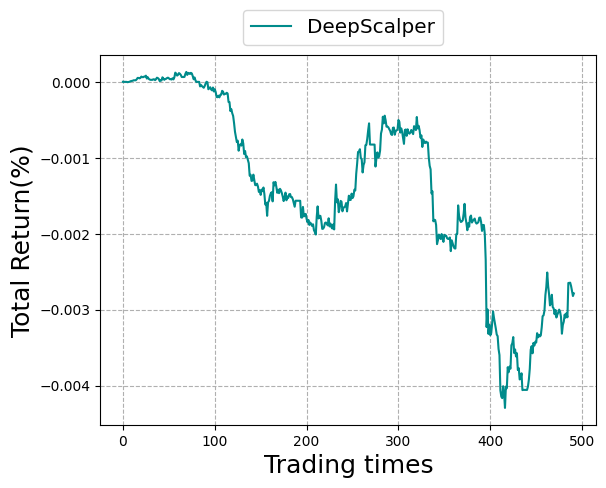

In [17]:
plot(trainer.test_environment.save_asset_memory(),alg="DeepScalper")